In [5]:
# Импорт необходимых библиотек

# возвращение списка (возможно, пустого) путей, соответствующих шаблону pathname
from glob import glob

# библиотека для работы с файлами
import os
import shutil

import random

In [6]:
from google.colab import drive # подключаем гугл драйв диск для загрузки файлов
#drive.mount('/content/drive')
drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


In [7]:
# загрузка датасета c Roboflow (ссылку берём при export dataset/show code/terminal)
!curl -L "https://app.roboflow.com/ds/3rGfNDNZc4?key=fphBhJ7yiW" > roboflow.zip
!unzip -q -o roboflow.zip -d /content/drive/MyDrive/Helmets
!rm roboflow.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   894  100   894    0     0    984      0 --:--:-- --:--:-- --:--:--   984
100 32.2M  100 32.2M    0     0  9122k      0  0:00:03  0:00:03 --:--:-- 14.6M


In [8]:
source_dir = '/content/drive/MyDrive/Helmets'

In [9]:
def get_file_paths(folder_with_labels):

    '''
    Функция для получения списка файлов в папке с путями к ним
    Args:
        folder_with_labels - адрес папки
    Return:
        список файлов с путями
    '''

    return glob(folder_with_labels, recursive=True)

In [10]:
def ch_class_num(path, old, new):

    '''
    Функция для замены номера класса в файле
    Args:
        path - путь с файлом
        old - старое значение (int)
        new - новое значение (int)
    Return:
        число замен (int)
    '''
    with open(path, 'r') as file1:

      new_list = []
      cnt = 0

      for line in file1:
        split_line = line.strip().split()
        new_str = split_line[0]

        if int(new_str) == old:
          cnt+=1
          split_line.pop(0)
          new_str = str(new)
          split_line.insert(0,new_str)

        out_str = ' '.join(map(str, split_line))
        new_list.append(out_str)

    with open(path, 'w') as file1:
      for  line in new_list:
        file1.write(line+ '\n')
    return cnt

```
У меня          Цель
0: 'Hardhat'    0: 'Hardhat'
1: 'No_Hardhat' 2: 'NO-Hardhat'
2: 'Person'     5: 'Person'
```



In [11]:
# Получаем список путей ко всем файлам меток с их именами
lbl_file_list = get_file_paths(source_dir + '/train/labels/' + '/**' + '/*.txt')

# Получаем список путей ко всем файлам картинок с их именами
img_file_list = get_file_paths(source_dir + '/train/images' + '/**' + '/*.jpg')

print(len(lbl_file_list))
print(lbl_file_list[0])

print(len(img_file_list))
print(img_file_list[0])

500
/content/drive/MyDrive/Helmets/train/labels/data1_0000396_jpg.rf.c8b2a60ff20fd962afa8e59f4148e48c.txt
500
/content/drive/MyDrive/Helmets/train/images/data1_0001608_jpg.rf.ddeb224af6d817b36bb57f0ff4f512ef.jpg


In [12]:
# делаем замену номера класса 2 на 5
cnt=0
for files in lbl_file_list:
  cnt+=ch_class_num(files,2,5)
print(f'Сделано {cnt} замен(ы) в {len(lbl_file_list)} файлах')

Сделано 884 замен(ы) в 500 файлах


In [13]:
# делаем замену номера класса 1 на 2
cnt=0
for files in lbl_file_list:
  cnt+=ch_class_num(files,1,2)
print(f'Сделано {cnt} замен(ы) в {len(lbl_file_list)} файлах')

Сделано 260 замен(ы) в 500 файлах




```
не забыть поправить наименование или порядок в yaml, если нужно
```



In [ ]:
# присланный вариант nc:10
data_yaml = '''
train: ../train/images
val: ../valid/images
test: ../test/images

nc: 10
names: ['Hardhat', 'Mask', 'NO-Hardhat', 'NO-Mask', 'NO-Safety Vest', 'Person', 'Safety Cone', 'Safety Vest', 'machinery', 'vehicle']

roboflow:
  workspace: rudn-17lnp
  project: hamlet-detection-system-2.0
  version: 1
  license: CC BY 4.0
  url: https://universe.roboflow.com/rudn-17lnp/hamlet-detection-system-2.0/dataset/1
'''

with open(source_dir + '/_data.yaml', 'w') as file:
    file.write(data_yaml)

In [14]:
def clf (file_list, cls):

    '''
    Функция из file_list формирует новый список файлов где встречается нужный
    номер класса cls
    Args:
        file_list - список файлов
        cls - искомый класс (int)
    Return:
        список файлов где встречается искомый класс
    '''
    new_files_list = []

    for fls in file_list:

     with open(fls, 'r') as file1:

        for line in file1:
          strip_line = line.strip()
          split_line = strip_line.split()

          if int(split_line[0]) == cls:
            new_files_list.append(fls)
            break

    return new_files_list


In [15]:
# Находим сколько файлов с персоной без каски
lbl_2_list = clf(lbl_file_list, 2)
# Проверим уникальность значений списка
print(len(lbl_2_list), len(set(lbl_2_list)))

183 183


In [16]:
# Находим сколько из них содержат персону с каскими
lbl_0_in_2_list = clf(lbl_2_list, 0)
print(len(lbl_0_in_2_list), len(set(lbl_0_in_2_list)))

17 17


In [17]:
# Находим разницу = сколько нужно добавить персон с касками для ровного набора
len(lbl_2_list) - len(lbl_0_in_2_list)

166

In [18]:
lbs_dir = source_dir + '/train/labels/'
img_dir = source_dir + '/train/images/'

new_lbs_dir = '/content/Helmets/train/_labels/'
new_img_dir = '/content/Helmets/train/_images/'

os.makedirs(new_lbs_dir, exist_ok=True)
os.makedirs(new_img_dir, exist_ok=True)

lbl_flist_tmp = lbl_file_list

for filename in lbl_flist_tmp:
    if filename in lbl_2_list:
      shutil.copy(lbs_dir + os.path.split(filename)[1],
                  new_lbs_dir + os.path.split(filename)[1])
      shutil.copy(img_dir + os.path.splitext(os.path.split(filename)[1])[0]+'.jpg',
                  new_img_dir + os.path.splitext(os.path.split(filename)[1])[0]+'.jpg')

random.shuffle(lbl_flist_tmp)
coutdown = len(lbl_2_list) - len(lbl_0_in_2_list)

for filename in lbl_flist_tmp:
    if (filename not in lbl_2_list) and (coutdown > 0):
      shutil.copy(lbs_dir + os.path.split(filename)[1],
                  new_lbs_dir + os.path.split(filename)[1])
      shutil.copy(img_dir + os.path.splitext(os.path.split(filename)[1])[0]+'.jpg',
                  new_img_dir + os.path.splitext(os.path.split(filename)[1])[0]+'.jpg')
      coutdown-=1

In [21]:
print(len(os.listdir(new_lbs_dir)), len(set(os.listdir(new_lbs_dir))))

349 349


In [23]:
print (len(os.listdir(new_img_dir)), len(set(os.listdir(new_img_dir))))

349 349


In [38]:
# Смотрим что получилось (код от Марины, немного изменен)
import numpy as np
import matplotlib.pyplot as plt

#функция для показа распределения классов в каждой выборке(папке)
def get_class_distribution(label_folder_path, name):

    # Получение списка файлов с метками
    label_files = [f for f in os.listdir(label_folder_path) if f.endswith('.txt')]

    # Извлечение меток классов
    labels = []
    for label_file in label_files:
       with open(os.path.join(label_folder_path, label_file), 'r') as file:
          for line in file:
              # Разделение строки на числа и добавление первого числа в список меток
              label = line.split()[0]
              labels.append(label)    # Вывод распределения классов
    unique_classes, counts = np.unique(labels, return_counts=True)

    # Получение реальных меток классов (предполагаем, что метки - целые числа)
    class_labels = [int(label) for label in unique_classes]

    fig, ax = plt.subplots()
    bars = ax.barh(class_labels, counts)
    ax.bar_label(bars)

    plt.show()

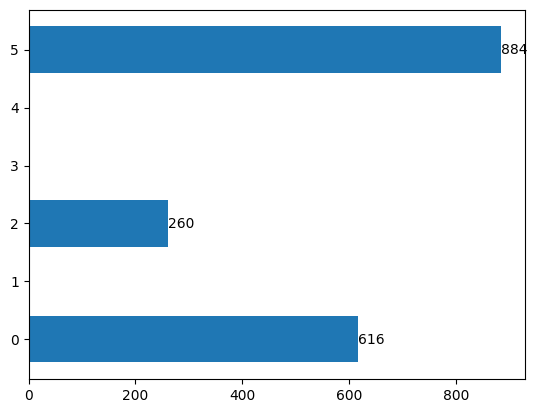

In [39]:
# До
get_class_distribution(lbs_dir,'Test')

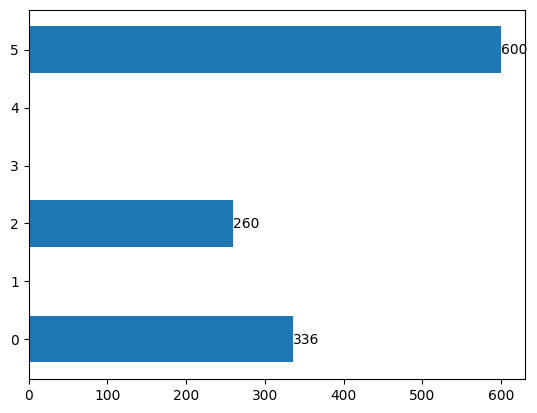

In [ ]:
# После
get_class_distribution(new_lbs_dir,'Test')

In [ ]:
print (os.path.splitext('/home/user/somefile.txt')[0]+'.jpg')

somefile.jpg


In [ ]:
os.path.splitext('/home/user/somefile.txt')[0]

'/home/user/somefile'

In [ ]:
os.path.split(lbl_file_list[0])[1]

'data1_0000396_jpg.rf.c8b2a60ff20fd962afa8e59f4148e48c.txt'

In [ ]:
#drv, pth = os.path.splitdrive(lbl_file_list[0])
pth, fname = os.path.split(lbl_file_list[0])
print(pth, fname)

/content/drive/MyDrive/Helmets/train/labels data1_0000396_jpg.rf.c8b2a60ff20fd962afa8e59f4148e48c.txt


In [ ]:
!rm -rf /content/Helmets